<a href="https://colab.research.google.com/github/IvoandricGBC/Project-MLI-GBC/blob/github_task/Multi_modal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Multi-modal Classification Colab

# ── Módulo 1 – Setup en Colab
from google.colab import drive
import os, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

drive.mount('/content/drive')
#!pip install --upgrade pip setuptools wheel
#!pip install torch torchvision pandas scikit-learn matplotlib

# ── Rutas y parámetros globales
BASE_DIR   = "/content/drive/MyDrive/Colab Notebooks/Multi-modal classification"
CSV_PATH   = os.path.join(BASE_DIR, "labels.csv")
IMGS_DIR   = os.path.join(BASE_DIR, "images")
MODEL_PATH = os.path.join(BASE_DIR, "best_embedder.pth")

assert os.path.isfile(CSV_PATH),  f"No existe {CSV_PATH}"
assert os.path.isdir(IMGS_DIR),   f"No existe {IMGS_DIR}"




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ── Módulo 3 – Preparación de datos
# 3.1 Leer CSV y remapear etiquetas

df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)
print(f"Labels mapped to 0...{num_classes-1}")

# 3.2 Construir columna de rutas e índices por etiqueta

df['image_path'] = df['ID'].astype(str) + '.png'
label_to_indices = {lbl: df.index[df['label_enc']==lbl].tolist()
                    for lbl in df['label_enc'].unique()}

# 3.3 Few-shot config y filtrado de clases
WAYS, SHOTS, QUERIES = 5, 1, 5
MIN_SAMPLES = SHOTS + QUERIES
valid_labels = [lbl for lbl, inds in label_to_indices.items()
                if len(inds) >= MIN_SAMPLES]
assert len(valid_labels) >= WAYS, "No hay suficientes clases válidas."




Labels mapped to 0...69


In [3]:
# ── Módulo 4 – Transforms de imagenes

train_img_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([.485,.456,.406],[.229,.224,.225]),
])
val_img_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([.485,.456,.406],[.229,.224,.225]),
])

In [4]:
# ── Módulo 5 – Función de muestreo de episodios

def sample_episode(df, label_to_indices, valid_labels,
                   ways, shots, queries, img_trans, img_dir):
    chosen = random.sample(valid_labels, ways)
    supp, qry = [], []
    for lbl in chosen:
        ids = random.sample(label_to_indices[lbl], shots+queries)
        for i, idx in enumerate(ids):
            row = df.loc[idx]
            img = Image.open(os.path.join(img_dir, row.image_path)).convert('RGB')
            img = img_trans(img)
            meta = torch.tensor([row.ID, row['class'], row.Width, row.location], dtype=torch.float32)
            (supp if i<shots else qry).append((img, meta, lbl))
    # separar soporte y query
    s_imgs = torch.stack([x[0] for x in supp]);   s_meta = torch.stack([x[1] for x in supp]);   s_lbls = torch.tensor([x[2] for x in supp], dtype=torch.long)
    q_imgs = torch.stack([x[0] for x in qry]);    q_meta = torch.stack([x[1] for x in qry]);    q_lbls = torch.tensor([x[2] for x in qry], dtype=torch.long)
    return s_imgs, s_meta, s_lbls, q_imgs, q_meta, q_lbls



In [5]:
# ── Módulo 6 – Definición del modelo multimodal

class MultiModalEmbedder(nn.Module):
    def __init__(self, backbone='resnet18', img_dim=128, meta_dim=32):
        super().__init__()
        cnn = getattr(models, backbone)(weights=models.ResNet18_Weights.DEFAULT)
        cnn.fc = nn.Linear(cnn.fc.in_features, img_dim)
        self.img_enc  = cnn
        self.meta_enc = nn.Sequential(
            nn.Linear(4,64), nn.ReLU(),
            nn.Linear(64,meta_dim), nn.ReLU(),
        )
    def forward(self, img, meta):
        e1 = self.img_enc(img)
        e2 = self.meta_enc(meta)
        return torch.cat([e1,e2], dim=1)


In [6]:
# ── Módulo 7 – Pérdida prototípica

def prototypical_loss(emb, ways, shots, queries):
    D = emb.size(-1)
    s = emb[:ways*shots].view(ways, shots, D)
    q = emb[ways*shots:].view(ways*queries, D)
    proto = s.mean(dim=1)
    dists = torch.cdist(q, proto)
    logits = -dists
    targets = torch.arange(ways).unsqueeze(1).expand(ways,queries).reshape(-1).to(logits.device)
    loss = nn.CrossEntropyLoss()(logits, targets)
    acc  = (logits.argmax(1)==targets).float().mean().item()
    return loss, acc

# ── Preparar modelo y decidir si entrenar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedder = MultiModalEmbedder().to(device)

if os.path.isfile(MODEL_PATH):
    embedder.load_state_dict(torch.load(MODEL_PATH))
    embedder.eval()
    print(f"✅ Loaded trained model from {MODEL_PATH}")
    skip_training = True
else:
    skip_training = False


✅ Loaded trained model from /content/drive/MyDrive/Colab Notebooks/Multi-modal classification/best_embedder.pth


In [7]:
# ── Módulo 8 – Entrenamiento, validación y guardado de best model

if not skip_training:
    optimizer = optim.Adam(embedder.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    best_val_acc, patience_counter, PATIENCE = 0.0, 0, 3
    train_losses, val_losses = [], []
    train_accs, val_accs     = [], []

    for epoch in range(1, 11):
        # Training
        embedder.train()
        rl, ra = 0.0, 0.0
        for _ in range(200):
            si, sm, sl, qi, qm, ql = sample_episode(
                df, label_to_indices, valid_labels,
                WAYS, SHOTS, QUERIES,
                train_img_transforms, IMGS_DIR)
            si, sm, sl = si.to(device), sm.to(device), sl.to(device)
            qi, qm     = qi.to(device), qm.to(device)
            emb_s, emb_q = embedder(si, sm), embedder(qi, qm)
            emb_all = torch.cat([emb_s, emb_q], dim=0)
            loss, acc = prototypical_loss(emb_all, WAYS, SHOTS, QUERIES)
            optimizer.zero_grad(); loss.backward()
            torch_utils.clip_grad_norm_(embedder.parameters(), 1.0)
            optimizer.step()
            rl += loss.item(); ra += acc
        tl, ta = rl/200, ra/200
        # Validation
        embedder.eval(); rvl, rva = 0.0, 0.0
        with torch.no_grad():
            for _ in range(50):
                si, sm, sl, qi, qm, ql = sample_episode(
                    df, label_to_indices, valid_labels,
                    WAYS, SHOTS, QUERIES,
                    val_img_transforms, IMGS_DIR)
                si, sm, sl = si.to(device), sm.to(device), sl.to(device)
                qi, qm     = qi.to(device), qm.to(device)
                emb_s, emb_q = embedder(si, sm), embedder(qi, qm)
                emb_all = torch.cat([emb_s, emb_q], dim=0)
                loss, acc = prototypical_loss(emb_all, WAYS, SHOTS, QUERIES)
                rvl += loss.item(); rva += acc
        vl, va = rvl/50, rva/50
        train_losses.append(tl); train_accs.append(ta)
        val_losses.append(vl); val_accs.append(va)
        # Early stopping + checkpoint
        if va > best_val_acc:
            best_val_acc = va
            torch.save(embedder.state_dict(), MODEL_PATH)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"⏹ Early stopping on epoch {epoch}")
                break
        scheduler.step(vl)
        print(f"Epoch {epoch:02d}  "
              f"TrainLoss={tl:.4f}  TrainAcc={ta:.4f}  |  "
              f"ValLoss={vl:.4f}  ValAcc={va:.4f}")
    # Plot metrics
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, '-o', label='Train Loss')
    plt.plot(epochs, val_losses,   '-o', label='Val Loss')
    plt.legend(); plt.title('Loss Curves'); plt.show()
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_accs, '-o', label='Train Acc')
    plt.plot(epochs, val_accs,   '-o', label='Val Acc')
    plt.legend(); plt.title('Accuracy Curves'); plt.show()
else:
    print("⚡ Skipping training; model loaded.")



⚡ Skipping training; model loaded.


Random batch indices: [6, 206, 181, 209, 172]
Random batch predictions: [44, 69, 32, 37, 41]
=== Classification Report ===
              precision    recall  f1-score   support

          11     0.0000    0.0000    0.0000         1
          15     0.0000    0.0000    0.0000         1
          20     0.6667    1.0000    0.8000         2
          23     0.2500    1.0000    0.4000         1
          27     0.0000    0.0000    0.0000         1
          29     0.0000    0.0000    0.0000         1
          31     1.0000    1.0000    1.0000         2
          32     0.6667    1.0000    0.8000         2
          33     0.3333    1.0000    0.5000         1
          34     0.7500    1.0000    0.8571         3
          35     0.6667    0.4000    0.5000         5
          36     0.2500    0.5000    0.3333         2
          37     0.3333    0.5000    0.4000         2
          38     0.7500    0.7500    0.7500         4
          39     0.6667    0.6667    0.6667         3
          40

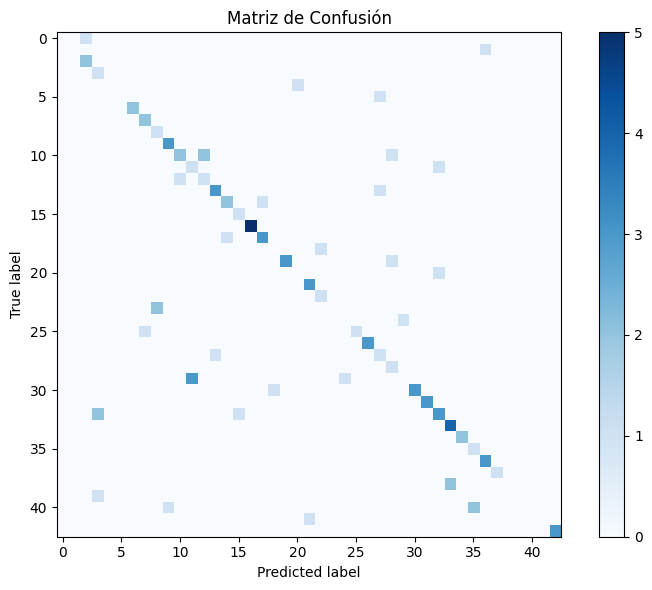

In [10]:

# ── Módulo 9 – Inferencia por batch
# Precompute prototypes (uses SHOTS support examples)
from collections import defaultdict
proto_sums, proto_counts = defaultdict(lambda: torch.zeros(embedder.img_enc.fc.out_features + embedder.meta_enc[-2].out_features).to(device)), defaultdict(int)
with torch.no_grad():
    for lbl in valid_labels:
        idxs = random.sample(label_to_indices[lbl], min(len(label_to_indices[lbl]), SHOTS))
        for idx in idxs:
            row = df.loc[idx]
            img  = val_img_transforms(Image.open(os.path.join(IMGS_DIR,row.image_path))).unsqueeze(0).to(device)
            meta = torch.tensor([[row.ID,row['class'],row.Width,row.location]],dtype=torch.float32).to(device)
            emb  = embedder(img,meta).squeeze(0)
            proto_sums[lbl]   += emb; proto_counts[lbl] += 1
prototypes     = {lbl:(proto_sums[lbl]/proto_counts[lbl]).unsqueeze(0) for lbl in valid_labels}
proto_tensor   = torch.cat(list(prototypes.values()),dim=0)

# Batch classification function
def classify_batch(image_paths, metadatas):
    imgs = torch.stack([val_img_transforms(Image.open(p).convert('RGB')) for p in image_paths]).to(device)
    metas= torch.tensor([[m['ID'],m['class'],m['Width'],m['location']] for m in metadatas],dtype=torch.float32).to(device)
    with torch.no_grad():
        embs  = embedder(imgs, metas)
        dists = torch.cdist(embs, proto_tensor)
        ids   = torch.argmin(dists, dim=1).cpu().numpy()
    labels_enc = [ valid_labels[i] for i in ids ]
    return le.inverse_transform(labels_enc).tolist()

# ── Example: Classify a random batch of 5 images
indices = random.sample(range(len(df)), 5)
paths   = [os.path.join(IMGS_DIR, df.iloc[i].image_path) for i in indices]
metas   = [
    {'ID':df.iloc[i].ID,'class':df.iloc[i]['class'],
     'Width':df.iloc[i].Width,'location':df.iloc[i].location}
    for i in indices
]
preds   = classify_batch(paths, metas)
print("Random batch indices:", indices)
print("Random batch predictions:", preds)

# ── Módulo 10 – Evaluación rápida con matriz de confusión y reporte de clasificación

from sklearn.metrics import confusion_matrix, classification_report

# 10.1 Configura cuántas muestras vas a evaluar
N_EVAL = 100
eval_indices = random.sample(range(len(df)), N_EVAL)

# 10.2 Prepara rutas, metadatos y etiquetas verdaderas
eval_paths = [
    os.path.join(IMGS_DIR, df.iloc[i].image_path)
    for i in eval_indices
]
eval_metas = [
    {
        'ID': df.iloc[i].ID,
        'class': df.iloc[i]['class'],
        'Width': df.iloc[i].Width,
        'location': df.iloc[i].location
    }
    for i in eval_indices
]
eval_true = df.iloc[eval_indices]['label'].tolist()

# 10.3 Ejecuta la predicción batch
eval_preds = classify_batch(eval_paths, eval_metas)

# 10.4 Imprime el classification report
print("=== Classification Report ===")
print(classification_report(eval_true, eval_preds, zero_division=0, digits=4))

# 10.5 Dibuja la matriz de confusión
cm = confusion_matrix(eval_true, eval_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.tight_layout()
plt.show()
